In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy import fft

from nalger_helper_functions import conforming_grid_convolution, conforming_box, make_regular_grid, plot_rectangle

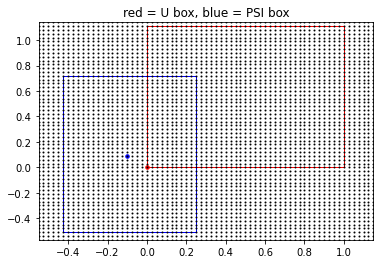

In [74]:
hh = np.array([0.025, 0.03])

U_centerpoint = np.zeros(2)
min_U, max_U, U_shape = conforming_box(np.array([0., 0.]), np.array([1., 1.1]), U_centerpoint, hh)

PSI_centerpoint = np.round(np.array([-0.1, 0.1]) / hh) * hh
min_PSI, max_PSI, PSI_shape = conforming_box(np.array([-0.4, -0.5]), np.array([0.23, 0.7]), PSI_centerpoint, hh)

min_plot, max_plot, plot_shape = conforming_box(np.min([min_U, min_PSI])-hh, np.max([max_U, max_PSI])+hh, 
                                                np.zeros(2), hh)

d = len(min_PSI)

_, (XPSI, YPSI) = make_regular_grid(min_PSI, max_PSI, PSI_shape)
_, (XU, YU) = make_regular_grid(min_U, max_U, U_shape)
_, (X, Y) = make_regular_grid(min_plot, max_plot, plot_shape)

plt.figure()

r1 = plot_rectangle(min_U, max_U, edgecolor='r')
plt.plot(U_centerpoint[0], U_centerpoint[1], '.r', markersize=7)

r2 = plot_rectangle(min_PSI, max_PSI, edgecolor='b')
plt.plot(PSI_centerpoint[0], PSI_centerpoint[1], '.b', markersize=7)

plt.plot(X[:], Y[:], '.k', markersize=2)

plt.xlim(min_plot[0], max_plot[0])
plt.ylim(min_plot[1], max_plot[1])

plt.title('red = U box, blue = PSI box')

plt.show()

In [75]:
def make_2D_grid_gaussian(mu, Sigma, X, Y):
    d = len(X.shape)
    C = np.power(2 * np.pi, -d/2.) * np.power(np.linalg.det(Sigma), -1./2.)
    
    zz = np.vstack([X.reshape(-1), Y.reshape(-1)]) - mu.reshape((-1,1))
    F = C * np.exp(-0.5 * np.sum(zz * np.linalg.solve(Sigma, zz), axis=0).reshape(-1)).reshape(X.shape)
    return F

<ipython-input-76-ed2529385173>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(XPSI, YPSI, PSI)


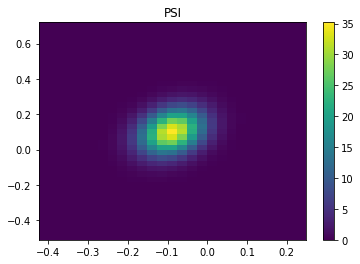

In [76]:
mu = PSI_centerpoint
Sigma = np.array([[0.004, 0.0015], 
                  [0.0015, 0.011]])*0.7

PSI = make_2D_grid_gaussian(mu, Sigma, XPSI, YPSI)
# PSI = make_2D_grid_gaussian(mu, Sigma, XPSI, YPSI) * np.sin(10*XPSI + 8*YPSI)

plt.pcolor(XPSI, YPSI, PSI)
plt.title('PSI')
plt.colorbar()

<ipython-input-77-ff731dadb97b>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(XPSI, YPSI, PSI_shifted)


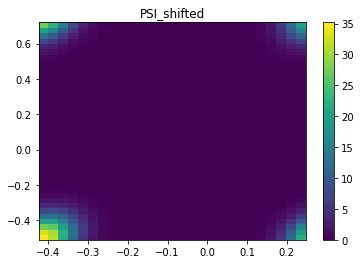

In [77]:
PSI_centerpoint_inds = np.round((mu - min_PSI) / hh).astype(int)

PSI_shifted = np.roll(PSI, -PSI_centerpoint_inds, axis=np.arange(PSI.ndim))

plt.pcolor(XPSI, YPSI, PSI_shifted)
plt.title('PSI_shifted')
plt.colorbar()

In [78]:
def square_root(z, branch_cut_theta):
    "Square root with different branch cut defined by theta parameter."
    #https://flothesof.github.io/branch-cuts-with-square-roots.html
    argument = np.angle(z) # between -pi and +pi
    modulus = np.abs(z)
    argument = np.mod(argument + branch_cut_theta, 2 * np.pi) - branch_cut_theta
    return np.sqrt(modulus) * np.exp(1j * argument / 2)

imag_fraction= 4.6684552806904556e-14


<ipython-input-79-82cb1b613b52>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(XPSI, YPSI, Z_shifted.real)


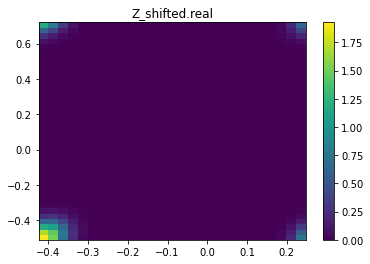

In [79]:
Z_shifted = fft.ifft2(square_root(fft.fft2(PSI_shifted), 1.0*np.pi))
imag_fraction = np.linalg.norm(Z_shifted.imag) / np.linalg.norm(Z_shifted)
print('imag_fraction=', imag_fraction)

plt.pcolor(XPSI, YPSI, Z_shifted.real)
plt.title('Z_shifted.real')
plt.colorbar()

<ipython-input-80-1fb360a961d6>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(XPSI, YPSI, Z)


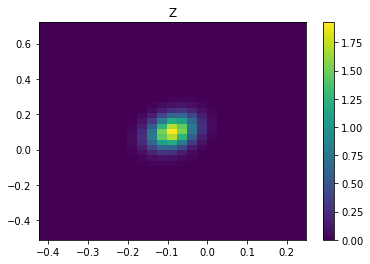

In [80]:
Z = np.roll(Z_shifted, PSI_centerpoint_inds, axis=np.arange(Z_shifted.ndim)).real

plt.pcolor(XPSI, YPSI, Z)
plt.title('Z')
plt.colorbar()

<ipython-input-81-58eee0838d32>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(XU, YU, U)


Text(0.5, 1.0, 'U')

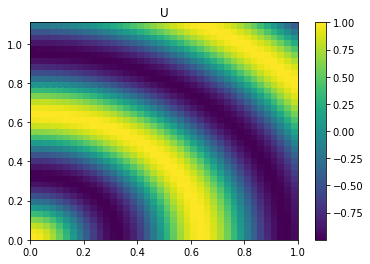

In [81]:
U = np.cos(10*np.sqrt(XU**2 + YU**2))

plt.pcolor(XU, YU, U)
plt.colorbar()
plt.title('U')

<ipython-input-82-11edd09350ea>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(XTU, YTU, TU)


Text(0.5, 1.0, 'TU')

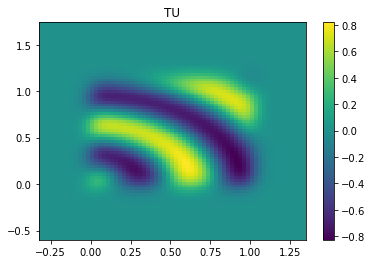

In [82]:
TU, min_TU, max_TU = conforming_grid_convolution(PSI, min_PSI, max_PSI, U, min_U, max_U, 
                                                 p1=PSI_centerpoint, p2=U_centerpoint)

_, (XTU, YTU) = make_regular_grid(min_TU, max_TU, TU.shape)

plt.pcolor(XTU, YTU, TU)
plt.colorbar()
plt.title('TU')

<ipython-input-83-01f8a3ee59b1>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(XsqrtTU, YsqrtTU, sqrtTU)


Text(0.5, 1.0, 'sqrtTU')

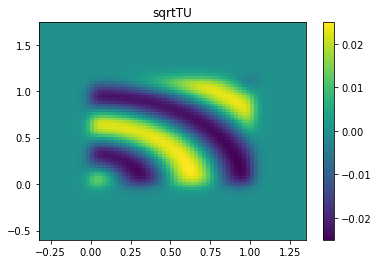

In [83]:
sqrtTU, min_sqrtTU, max_sqrtTU = conforming_grid_convolution(Z, min_PSI, max_PSI, U, min_U, max_U, 
                                                             p1=PSI_centerpoint, p2=U_centerpoint)

_, (XsqrtTU, YsqrtTU) = make_regular_grid(min_sqrtTU, max_sqrtTU, sqrtTU.shape)

plt.pcolor(XsqrtTU, YsqrtTU, sqrtTU)
plt.colorbar()
plt.title('sqrtTU')

<ipython-input-84-b64134582785>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(XTU2, YTU2, TU2)


Text(0.5, 1.0, 'TU2')

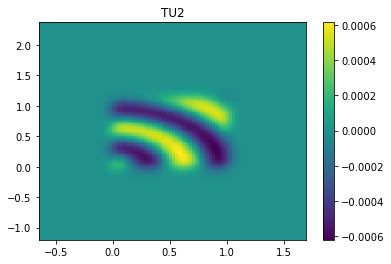

In [84]:
TU2, min_TU2, max_TU2 = conforming_grid_convolution(Z, min_PSI, max_PSI, sqrtTU, min_sqrtTU, max_sqrtTU, 
                                                    p1=PSI_centerpoint, p2=U_centerpoint)

_, (XTU2, YTU2) = make_regular_grid(min_TU2, max_TU2, TU2.shape)

plt.pcolor(XTU2, YTU2, TU2)
plt.colorbar()
plt.title('TU2')

In [85]:
np.sqrt(1./np.prod(hh))

36.51483716701107

1333.3334353217172


<ipython-input-86-80af988a4c93>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(XTU, YTU, TU2_clipped / np.prod(hh) - TU)


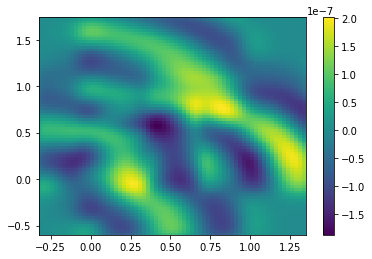

In [86]:
ii_min = tuple(np.round((min_TU - min_TU2) / hh).astype(int))
ii_max = tuple(np.round((max_TU - min_TU2) / hh).astype(int))

TU2_clipped = TU2[ii_min[0]:ii_max[0]+1, ii_min[1]:ii_max[1]+1]

print(np.max(TU) / np.max(TU2_clipped))

plt.pcolor(XTU, YTU, TU2_clipped / np.prod(hh) - TU)
plt.colorbar()

In [32]:
TU2_clipped.shape

(68, 67)

In [33]:
TU.shape

(68, 67)

In [37]:
np.linalg.norm(TU - TU2_clipped)

19.76088501064949

<ipython-input-7-29323586d405>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, Y1, FZ.real)
<ipython-input-7-29323586d405>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, Y1, FZ.imag)


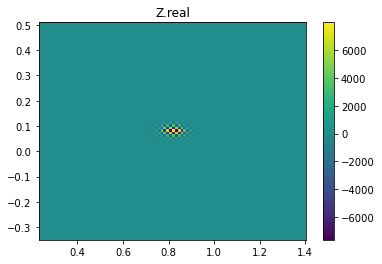

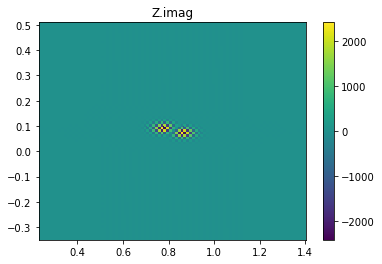

In [7]:
FZ = fft.fftshift(fft.fft2(PSI))

plt.pcolor(X1, Y1, FZ.real)
plt.title('Z.real')
plt.colorbar()

plt.figure()
plt.pcolor(X1, Y1, FZ.imag)
plt.title('Z.imag')
plt.colorbar()

imag_fraction= 1.4364603009567537e-16


<ipython-input-8-021c73cae50f>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, Y1, Z.real)


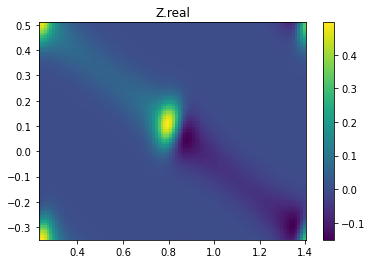

In [8]:
Z = fft.ifft2(square_root(fft.fft2(PSI),1.0*np.pi))
imag_fraction= np.linalg.norm(Z.imag) / np.linalg.norm(Z)
print('imag_fraction=', imag_fraction)

plt.pcolor(X1, Y1, Z.real)
plt.title('Z.real')
plt.colorbar()

In [19]:
print('(max_G2 - min_G2) / hh=', (max_G2 - min_G2) / hh)
print('G2.shape=', G2.shape)

print('(max1 - min1) / hh=', (max1 - min1) / hh)
print('Z3.shape=', Z3.shape)

(min_G2 - min1) / hh

(max_G2 - min_G2) / hh= [244. 183.]
G2.shape= (245, 184)
(max1 - min1) / hh= [94. 86.]
Z3.shape= (95, 87)


array([-87.6, -78. ])

In [179]:
G3, min_G3, max_G3 = conforming_grid_convolution(Z3, min1, max1, G2, min_G2, max_G2)

_, (XG3, YG3) = make_regular_grid(min_G3, max_G3, G3.shape)

plt.pcolor(XG3, YG3, G3)
plt.title('G3')

RuntimeError: Grids not conforming (one grid is shifted relative to the other)

F1_volume= 1.35


<ipython-input-3-e66f16e5cc3a>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, Y1, F1)


Text(0.5, 1.0, 'F1')

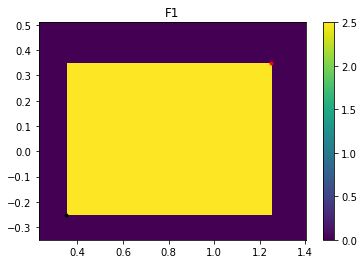

In [3]:
b_width = 0.9
b_height = 0.6

F1 = 2.5 * (p1[0] < X1) * (X1 < p1[0] + b_width) * (p1[1] < Y1) * (Y1 < p1[1] + b_height)

element_volume = np.prod(hh)
F1_volume = np.sum(F1) * element_volume
print('F1_volume=', F1_volume)

plt.pcolor(X1, Y1, F1)
plt.colorbar()
plt.plot(p1[0], p1[1], '.k')
plt.plot(p1[0] + b_width, p1[1] + b_height, '.r')
plt.title('F1')

F2_volume= 0.9999984661196425


<ipython-input-4-2123268cb662>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X2, Y2, F2)


Text(0.5, 1.0, 'F2')

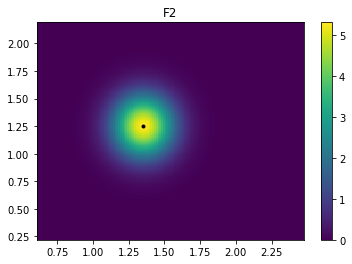

In [4]:
def make_2D_grid_gaussian(mu, Sigma, X, Y):
    d = len(X.shape)
    C = np.power(2 * np.pi, -d/2.) * np.power(np.linalg.det(Sigma), -1./2.)
    
    zz = np.vstack([X.reshape(-1), Y.reshape(-1)]) - mu.reshape((-1,1))
    F = C * np.exp(-0.5 * np.sum(zz * np.linalg.solve(Sigma, zz), axis=0).reshape(-1)).reshape(X.shape)
    return F

ss = np.array([0.15, 0.2])
Sigma = np.diag(ss**2)
F2 = make_2D_grid_gaussian(p2, Sigma, X2, Y2)

F2_volume = np.sum(F2) * element_volume
print('F2_volume=', F2_volume)

plt.pcolor(X2, Y2, F2)
plt.colorbar()
plt.plot(p2[0], p2[1], '.k')
plt.title('F2')

dt_fft= 0.002888202667236328
dt_direct= 5.544432163238525
dt_auto= 0.004232645034790039
F3_volume= 1.3499979292615174


<ipython-input-5-d31c9de3779f>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X3, Y3, F3)


Text(0.5, 1.0, 'convolution of f1(x-p1) and f2(x-p2)')

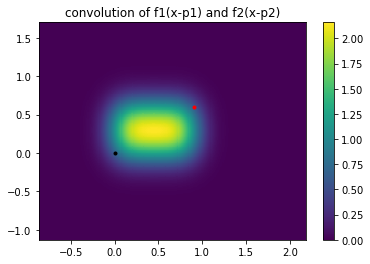

In [5]:
t = time()
F3, min3, max3 = conforming_grid_convolution(F1, min1, max1, F2, min2, max2, p1=p1, p2=p2, method='fft')
dt_fft = time() - t
print('dt_fft=', dt_fft)

t = time()
F3, min3, max3 = conforming_grid_convolution(F1, min1, max1, F2, min2, max2, p1=p1, p2=p2, method='direct')
dt_direct = time() - t
print('dt_direct=', dt_direct)

t = time()
F3, min3, max3 = conforming_grid_convolution(F1, min1, max1, F2, min2, max2, p1=p1, p2=p2, method='auto')
dt_auto = time() - t
print('dt_auto=', dt_auto)

F3_volume = np.sum(F3) * element_volume
print('F3_volume=', F3_volume)

xx3 = np.linspace(min3[0], max3[0], F3.shape[0])
yy3 = np.linspace(min3[1], max3[1], F3.shape[1])
X3, Y3 = np.meshgrid(xx3, yy3, indexing='ij')

plt.pcolor(X3, Y3, F3)
plt.colorbar()

plt.plot(0, 0, '.k')
plt.plot(b_width, b_height, '.r')
plt.title('convolution of f1(x-p1) and f2(x-p2)')

<ipython-input-6-b4d1717ed216>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, Y1, G_A)
<ipython-input-6-b4d1717ed216>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X2, Y2, G_B)


Text(0.5, 1.0, 'G_B')

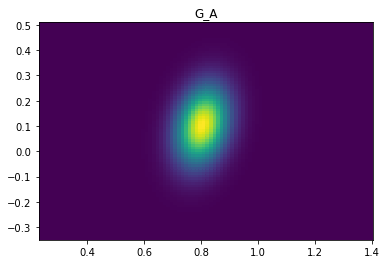

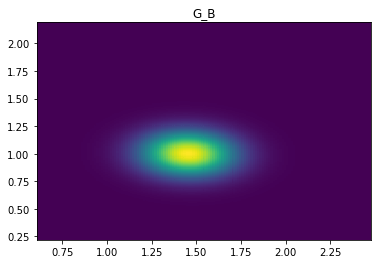

In [6]:
mu_A = np.array([0.8, 0.1])
Sigma_A = np.array([[0.004, 0.0015], 
                    [0.0015, 0.011]])
G_A = make_2D_grid_gaussian(mu_A, Sigma_A, X1, Y1)

plt.pcolor(X1, Y1, G_A)
plt.title('G_A')

mu_B = np.array([1.45, 1.0])
Sigma_B = np.array([[0.033, -0.001], 
                    [-0.001, 0.020]])
G_B = make_2D_grid_gaussian(mu_B, Sigma_B, X2, Y2)

plt.figure()
plt.pcolor(X2, Y2, G_B)
plt.title('G_B')

<ipython-input-7-43995a7f4f37>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X_C, Y_C, G_C)
<ipython-input-7-43995a7f4f37>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X_C, Y_C, G_C_true)


err_conv= 4.2707996909004765e-05


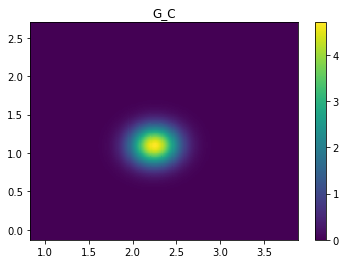

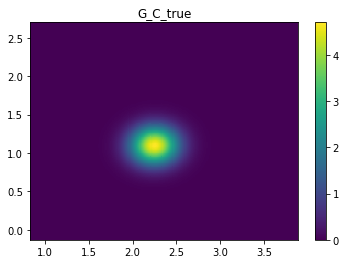

In [7]:
G_C, min5, max5 = conforming_grid_convolution(G_A, min1, max1, G_B, min2, max2, method='fft')

xx_C = np.linspace(min5[0], max5[0], G_C.shape[0])
yy_C = np.linspace(min5[1], max5[1], G_C.shape[1])
X_C, Y_C = np.meshgrid(xx_C, yy_C, indexing='ij')

plt.figure()
plt.pcolor(X_C, Y_C, G_C)
plt.colorbar()
plt.title('G_C')

G_C_true = make_2D_grid_gaussian(mu_A + mu_B, Sigma_A + Sigma_B, X_C, Y_C)

plt.figure()
plt.pcolor(X_C, Y_C, G_C_true)
plt.colorbar()
plt.title('G_C_true')

err_conv = np.linalg.norm(G_C - G_C_true) / np.linalg.norm(G_C_true)
print('err_conv=', err_conv)